# Pure NN 
The goal in this notebook is to reproduce results similar to Sindre Blakseths paper about CoSTA
## Contents:
- Imports and configs
- Data preparation
- Model training

## Imports and configs

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [23]:
### Configs for the notebook, changeable

# Modelling
p=1 # element polynomial order
Ne = 20 # number of elements (spacial)
T = 5 # Max time
time_steps=200 # Number of time steps
k = T/time_steps # time step length
alpha = 1

# NN architecture
hidden_layers = 3
hidden_layar_depth = 80
learning_rate = 1e-4
lrelu_slope = 0.01


### Constants
tri = np.linspace(0,1,Ne+1)

## Data prep
Making the data sets takes some time, so if this is done already, skip and load below

In [24]:
### Make data sets

def data_set(alphas):
    '''This function makes data set for ham and pnn training/validation with alphas as given
    give alpha_train for training data etc.
    Data is not shuffled or normalized, nor split in input/output, that should be done later'''
    pnn_data = np.zeros((len(alphas)*time_steps, Ne+1 + Ne-1)) #Ne+1 for X, Ne-1 for Y
    for i, alpha in enumerate(alphas):

        u_ex = lambda x,t=T: 1+np.sin(2*np.pi*t+alpha)*np.cos(2*np.pi*x)
        
        for t in range(time_steps):
            
            # we set the pnn_data as the exact temperature u_ex
            pnn_data[time_steps*i + t, :Ne+1] = u_ex(x=tri, t=t*k) # input: exact solution
            pnn_data[time_steps*i + t, Ne+1:] = u_ex(x=tri[1:-1], t=(t+1)*k) # outout: inner nodes, next step


    return pnn_data

pnn_train_data = data_set(alpha_test)
pnn_val_data = data_set(alpha_val)

df_pnn_train = pd.DataFrame(pnn_train_data, columns=[*[f'i{x}' for x in tri],*[f'nf{i}' for i in np.arange(neck_feats)], *[f'o{x}' for x in tri[1:-1]]])
df_pnn_val = pd.DataFrame(pnn_val_data, columns=[*[f'i{x}' for x in tri],*[f'nf{i}' for i in np.arange(neck_feats)], *[f'o{x}' for x in tri[1:-1]]])



In [26]:
### make data sets ready:

# As long as val and train is the same alphas, we use the same data
if alpha_val == alpha_train:
    df_pnn_val = df_pnn_train.copy()

# Shuffle
df_pnn_train = df_pnn_train.sample(frac=1)
df_pnn_val = df_pnn_val.sample(frac=1)

# Get numpy arrays
pnn_train = df_pnn_train.values
pnn_val = df_pnn_val.values

# Split intp input (X) and output (Y)
pnn_train_X = pnn_train[:, :Ne+1]
pnn_train_Y = pnn_train[:, Ne+1:]
pnn_val_X = pnn_val[:, :Ne+1]
pnn_val_Y = pnn_val[:, Ne+1:]

# Normalize, for each input
if 0:
    pnn_mean= pnn_train_X.mean(0)
    pnn_var = pnn_train_X.var(0)
    print(pnn_var)
    epsilon = 0.001
    for i in range(Ne+1)
        pnn_train_X[:,i] = (pnn_train_X[:,i]-pnn_mean[i]) / (pnn_var[i]+epsilon)**0.5
        pnn_val_X[:,i] = (pnn_val_X[:,i]-pnn_mean[i]) / (pnn_var[i]+epsilon)**0.5

## Model initialisation and training

In [30]:
def get_model():

    inputs = tf.keras.Input(shape=(Ne+1))
    x = inputs
    for h in range(hidden_layers):
        x = tf.keras.layers.Dense(hidden_layar_depth)(x)
        x = tf.keras.layers.LeakyReLU(alpha=lrelu_slope)(x)
    x = tf.keras.layers.Dense(Ne-1)(x)
    model = tf.keras.Model(inputs,x)
    model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return model

pureNN = get_model()

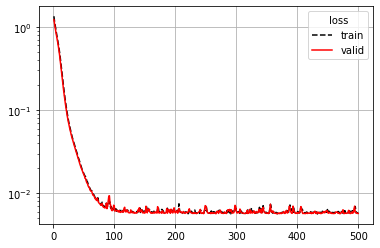

In [31]:
# train
pnn_hist = pureNN.fit(x=pnn_train_X, y=pnn_train_Y, epochs=500, verbose=0, batch_size = 32,  validation_data=(pnn_val_X, pnn_val_Y))

# plot loss
epochs_vector = np.arange(1, len(pnn_hist.history['loss'])+1)
plt.plot(epochs_vector, pnn_hist.history['loss'], 'k--', label='train')
plt.plot(epochs_vector, pnn_hist.history['val_loss'], 'r', label='valid')
plt.yscale('log')
plt.grid()
plt.legend(title='loss')
plt.show()

## Testing

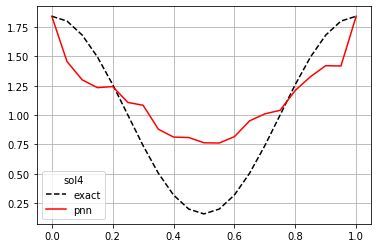

In [32]:
# start by testing pnn:
for alpha in alpha_test:

    u_ex = lambda x,t=T: 1+np.sin(2*np.pi*t+alpha)*np.cos(2*np.pi*x)

    u = u_ex(x=tri, t=0)


    for t in range(time_steps):
        u_prev = u # set u_prev (used as model input) as the previous step
        u_prev = np.array([u_prev]) # this format is needed for NN
        u = u_ex(t=(t+1)*k, x = tri) # set the next u (only boundary is kept, the rest is overwritten)
        u[1:-1] = pureNN(u_prev)



    plt.plot(tri,u_ex(t=T,x=tri), 'k--', label='exact')
    plt.plot(tri,u, 'r', label='pnn')
    plt.grid()
    plt.legend(title=f'sol{sol}')
    plt.show()
